In [1]:
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq '/content/drive/MyDrive/Model/data.zip'

In [4]:
import os
import glob
import math
from tqdm import tqdm
import numpy as np
import pandas as pd
from google.colab import files

import torch
import torchvision
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, Subset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchinfo import summary

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from matplotlib import pyplot as plt
from PIL import Image

In [5]:
%cd drive/MyDrive/Model/notebook/py
!ls

/content/drive/MyDrive/Model/notebook/py
config.py	loss_total.png	runs		  training_results.txt	vae.py
data		__pycache__	test_results.txt  vae_decoder_best.pth
loss_total.npy	results		Training.py	  vae_encoder_best.pth


In [6]:
from Training import loss_function, training_and_testing
from vae import NeuralNet as nnet
import config as CFG

In [ ]:
# 이미지를 회전시키는 함수
def rotate_images(image):
    images = []
    for angle in [0, 90, 180, 270]:
        rotated_image = TF.rotate(image, angle)
        images.append(rotated_image)
    return images

# 이미지에 가우시안 노이즈를 추가하는 함수
def gauss_noise(image_tensor, sigma=0.05):
    noise = torch.randn(image_tensor.size()) * sigma
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

# 사용자 정의 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, gauss_sigma=0.05):
        self.root_dir = root_dir
        self.transform = transform
        self.gauss_sigma = gauss_sigma
        self.images = self.make_dataset()

    # 데이터셋을 만드는 함수
    def make_dataset(self):
        images = []
        for class_name in sorted(os.listdir(self.root_dir)):
            class_dir = os.path.join(self.root_dir, class_name)
            images.append(class_dir)
            # for img_name in os.listdir(class_dir):
            #     img_path = os.path.join(class_dir, img_name)
            #     images.append(img_path)
        return images

    def __len__(self):
        return len(self.images)

    # 데이터셋에서 아이템을 가져오는 함수
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            original_image = self.transform(image)  # 원본 이미지에 변환 적용
            noisy_image = gauss_noise(original_image, self.gauss_sigma)  # 가우시안 노이즈 추가
            rotated_images = rotate_images(image)  # 이미지 회전
            transformed_images = [self.transform(img) for img in rotated_images]  # 회전 이미지에 변환 적용
            noisy_images = [gauss_noise(img, self.gauss_sigma) for img in transformed_images]  # 회전 이미지에 노이즈 추가

            combined_images = [original_image, noisy_image] + transformed_images + noisy_images
            return combined_images
        else:
            return image

In [ ]:
trainset = torchvision.datasets.MNIST(root=r'/content/drive/MyDrive/Model/pre_data', train=True, download=True,
                                        transform=CFG.transform_pre)
indices = [i for i, target in enumerate(trainset.targets) if target == 0]
subset_0_class = Subset(trainset, indices)

pre_train_loader = DataLoader(dataset=subset_0_class, batch_size=64, shuffle=True,
                          num_workers=2)

In [ ]:
for inputs, targets in pre_train_loader:
    print(f"Batch inputs shape: {inputs.shape}")
    print(f"Batch targets: {targets}")
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch inputs shape: torch.Size([64, 1, 480, 480])
Batch targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Labels: 0 0 0 0 0


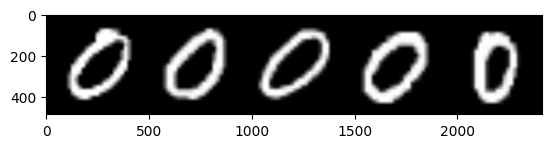

In [ ]:
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(pre_train_loader)
images, labels = next(dataiter)

num_images_to_show = 5
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(num_images_to_show)))

imshow(torchvision.utils.make_grid(images[:num_images_to_show]))

In [ ]:
folder = r'/content/data/Normal'
file_path = glob.glob(os.path.join(folder, "*.jpg"))

In [ ]:
train_size = int(0.9 * len(file_path))
test_size = len(file_path) - train_size

full_dataset = CustomDataset(root_dir=folder, transform=CFG.transform)

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=CFG.batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=CFG.batch_size, shuffle=False)

In [ ]:
neuralnet = nnet(height=CFG.height, width=CFG.width, channel=CFG.channel,
                 device=CFG.device, ngpu=CFG.ngpu)

The number of parameters: 19693.0000


In [ ]:
summary(neuralnet.encoder, input_size=(32, 1, 480, 480), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [32, 16, 20, 20]          --
├─Sequential: 1-1                        [32, 16, 20, 20]          --
│    └─Conv2d: 2-1                       [32, 4, 480, 480]         40
│    └─ELU: 2-2                          [32, 4, 480, 480]         --
│    └─Conv2d: 2-3                       [32, 4, 480, 480]         148
│    └─ELU: 2-4                          [32, 4, 480, 480]         --
│    └─AvgPool2d: 2-5                    [32, 4, 240, 240]         --
│    └─Conv2d: 2-6                       [32, 8, 240, 240]         296
│    └─ELU: 2-7                          [32, 8, 240, 240]         --
│    └─Conv2d: 2-8                       [32, 8, 240, 240]         584
│    └─ELU: 2-9                          [32, 8, 240, 240]         --
│    └─AvgPool2d: 2-10                   [32, 8, 120, 120]         --
│    └─Conv2d: 2-11                      [32, 8, 120, 120]         584
│    └─ELU:

In [ ]:
summary(neuralnet.decoder, input_size=(32, 16, 20, 20), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [32, 1, 480, 480]         --
├─Sequential: 1-1                        [32, 16, 20, 20]          --
│    └─Conv2d: 2-1                       [32, 16, 20, 20]          2,320
│    └─ELU: 2-2                          [32, 16, 20, 20]          --
├─Sequential: 1-2                        [32, 1, 480, 480]         --
│    └─Conv2d: 2-3                       [32, 16, 20, 20]          2,320
│    └─ELU: 2-4                          [32, 16, 20, 20]          --
│    └─Conv2d: 2-5                       [32, 16, 20, 20]          2,320
│    └─ELU: 2-6                          [32, 16, 20, 20]          --
│    └─Upsample: 2-7                     [32, 16, 60, 60]          --
│    └─Conv2d: 2-8                       [32, 16, 60, 60]          2,320
│    └─ELU: 2-9                          [32, 16, 60, 60]          --
│    └─Conv2d: 2-10                      [32, 8, 60, 60]           1,160


In [ ]:
def pretrain(neuralnet, train_loader, epochs):
    neuralnet.train(mode=True)
    best_loss = float('inf')  # Initialize best loss to a very high value

    for epoch in range(epochs):
        num_batches = len(train_loader)

        for i, input in enumerate(train_loader):
            input = inputs.to(CFG.device)
            conv_out = neuralnet.encoder(input)
            x_hat = neuralnet.decoder(conv_out)
            loss = loss_function(
                x=input, x_hat=x_hat
            )

            loss.backward()
            neuralnet.optimizer.step()
            neuralnet.optimizer.zero_grad()

            # Check if the current batch loss is the best we've seen so far
            if loss.item() < best_loss:
                best_loss = loss.item()
                print(f'New best model found at epoch {epoch + 1}, batch {i + 1}, saving model.')
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{num_batches}], Loss: {loss.item()}')
                # print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{num_batches}], Loss: {loss.item():.4f}, '
                #       f'Restore_error: {restore_error:.4f}, KL-Divergence: {kl_divergence:.6f}')
                torch.save(neuralnet.encoder.state_dict(), 'vae_encoder_best.pth')
                torch.save(neuralnet.decoder.state_dict(), 'vae_decoder_best.pth')

            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{num_batches}], Loss: {loss.item()}')


In [ ]:
neuralnet.to(CFG.device)
weight_device = neuralnet.encoder.encoder_conv[0].weight.device
print("Weight tensor of device:", weight_device)

Weight tensor of device: cuda:0


In [ ]:
 pretrain(neuralnet=neuralnet, train_loader=pre_train_loader, epochs=25)

New best model found at epoch 1, batch 1, saving model.
Epoch [1/25], Step [1/93], Loss: 0.12416663765907288
New best model found at epoch 1, batch 2, saving model.
Epoch [1/25], Step [2/93], Loss: 0.12117763608694077
New best model found at epoch 1, batch 3, saving model.
Epoch [1/25], Step [3/93], Loss: 0.11866939812898636
New best model found at epoch 1, batch 4, saving model.
Epoch [1/25], Step [4/93], Loss: 0.11634104698896408
New best model found at epoch 1, batch 5, saving model.
Epoch [1/25], Step [5/93], Loss: 0.11394887417554855
New best model found at epoch 1, batch 6, saving model.
Epoch [1/25], Step [6/93], Loss: 0.1113923192024231
New best model found at epoch 1, batch 7, saving model.
Epoch [1/25], Step [7/93], Loss: 0.10879355669021606
New best model found at epoch 1, batch 8, saving model.
Epoch [1/25], Step [8/93], Loss: 0.10663286596536636
New best model found at epoch 1, batch 9, saving model.
Epoch [1/25], Step [9/93], Loss: 0.10581115633249283
Epoch [1/25], Step [

KeyboardInterrupt: 

In [ ]:
def load_pretrained_model(encoder_path, decoder_path, device):
    neuralnet = nnet(height=CFG.height, width=CFG.width, channel=CFG.channel, device=CFG.device, ngpu=CFG.ngpu)
    neuralnet.encoder.load_state_dict(torch.load(encoder_path))
    neuralnet.decoder.load_state_dict(torch.load(decoder_path))
    return neuralnet

def calculate_heatmap(img, reconstructed_img):
    img_pil = to_pil_image(img.squeeze())
    reconstructed_img_pil = to_pil_image(reconstructed_img.squeeze())

    img_np = np.array(img_pil)
    reconstructed_img_np = np.array(reconstructed_img_pil)

    heatmap = np.zeros_like(img_np, dtype=np.float32)

    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            heatmap[i, j] = math.sqrt(math.pow(img_np[i, j] - reconstructed_img_np[i, j], 2))

    heatmap_tensor = torch.tensor(heatmap)
    return heatmap_tensor

def plot_histogram(heatmap_tensor):
    heatmap_np = heatmap_tensor.numpy()
    plt.hist(heatmap_np.ravel(), bins=256, range=(0.0, 0.1), fc='k', ec='k')
    plt.title("Histogram of Heatmap Values")
    plt.xlabel("Pixel Intensity Difference")
    plt.ylabel("Frequency")
    plt.ylim(0, 100)
    plt.show()

def plot_heatmap(heatmap_tensor):
    heatmap_np = heatmap_tensor.numpy()
    plt.imshow(heatmap_np, cmap='Reds')
    plt.colorbar()
    plt.title("Heatmap of Pixel Intensity Differences")
    plt.show()

def show_image(img):
    img = img.squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

vae = load_pretrained_model('/content/drive/MyDrive/Model/notebook/py/vae_encoder_best.pth', '/content/drive/MyDrive/Model/notebook/py/vae_decoder_best.pth', CFG.device)
vae.encoder.eval()
vae.decoder.eval()

# MNIST 데이터셋에서 0번 클래스가 아닌 다른 클래스의 이미지를 로드
mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=CFG.transform)
loader = DataLoader(mnist, batch_size=1, shuffle=True)

images = []
for img, label in loader:
  if label.item() == 0:
    images.append(img.to(CFG.device))
    break

for idx, (img, label) in enumerate(loader):
        images.append(img.to(CFG.device))
        if idx == 10:
          break

for img in images:
  with torch.no_grad():
    conv_out = vae.encoder(img)
    reconstructed_img = vae.decoder(conv_out)

  print("Reconstructed Image:")
  show_image(reconstructed_img)

  print("Original Image:")
  show_image(img)

  heatmap = calculate_heatmap(img, reconstructed_img)
  plot_heatmap(heatmap)
  plot_histogram(heatmap)

The number of parameters: 19693.0000


RuntimeError: Error(s) in loading state_dict for Encoder:
	Missing key(s) in state_dict: "encoder_conv.10.weight", "encoder_conv.10.bias", "encoder_conv.12.weight", "encoder_conv.12.bias", "encoder_conv.14.weight", "encoder_conv.14.bias", "encoder_conv.16.weight", "encoder_conv.16.bias". 
	Unexpected key(s) in state_dict: "encoder_conv.9.weight", "encoder_conv.9.bias", "encoder_conv.11.weight", "encoder_conv.11.bias", "encoder_conv.13.weight", "encoder_conv.13.bias", "encoder_conv.15.weight", "encoder_conv.15.bias". 

In [ ]:
training_and_testing(neuralnet=neuralnet ,train_dataset=train_dataset, test_dataset= test_dataset,
                      epochs=30, batch_size=CFG.batch_size)

Epoch [1], Step [1/208], Total Loss: 0.23180653154850006
Epoch [1], Step [11/208], Total Loss: 0.10970365256071091
Epoch [1], Step [21/208], Total Loss: 0.07317396253347397
Epoch [1], Step [31/208], Total Loss: 0.06528210639953613
Epoch [1], Step [41/208], Total Loss: 0.04064948856830597
Epoch [1], Step [51/208], Total Loss: 0.023044295608997345
Epoch [1], Step [61/208], Total Loss: 0.016743864864110947
Epoch [1], Step [71/208], Total Loss: 0.014579656533896923
Epoch [1], Step [81/208], Total Loss: 0.010838271118700504
Epoch [1], Step [91/208], Total Loss: 0.009007081389427185
Epoch [1], Step [101/208], Total Loss: 0.008229166269302368
Epoch [1], Step [111/208], Total Loss: 0.007456593215465546
Epoch [1], Step [121/208], Total Loss: 0.007169611286371946
Epoch [1], Step [131/208], Total Loss: 0.006559440866112709
Epoch [1], Step [141/208], Total Loss: 0.00647000502794981
Epoch [1], Step [151/208], Total Loss: 0.006164357997477055
Epoch [1], Step [161/208], Total Loss: 0.0063518718816339

In [12]:
# 이미지를 회전시키는 함수
def rotate_images(image):
    images = []
    for angle in [0, 90, 180, 270]:
        rotated_image = TF.rotate(image, angle)
        images.append(rotated_image)
    return images

# 이미지에 가우시안 노이즈를 추가하는 함수
def gauss_noise(image_tensor, sigma=0.05):
    noise = torch.randn(image_tensor.size()) * sigma
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image


# 사용자 정의 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, gauss_sigma=0.05):
        self.root_dir = root_dir
        self.transform = transform
        self.gauss_sigma = gauss_sigma
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    # 데이터셋을 만드는 함수
    def make_dataset(self):
        images = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                images.append((img_path, self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    # 데이터셋에서 아이템을 가져오는 함수
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            original_image = self.transform(image)  # 원본 이미지에 변환 적용
            noisy_image = gauss_noise(original_image, self.gauss_sigma)  # 가우시안 노이즈 추가
            rotated_images = rotate_images(image)  # 이미지 회전
            transformed_images = [self.transform(img) for img in rotated_images]  # 회전 이미지에 변환 적용
            noisy_images = [gauss_noise(img, self.gauss_sigma) for img in transformed_images]  # 회전 이미지에 노이즈 추가

            combined_images = [original_image, noisy_image] + transformed_images + noisy_images
            return combined_images, label  # 원본 변환 이미지만 반환
        else:
            return image, label

In [13]:
full_dataset = CustomDataset(root_dir='/content/data', transform=CFG.transform)

In [14]:
test_loader = DataLoader(dataset=full_dataset, batch_size=1, shuffle=True)

In [ ]:
def load_pretrained_model(encoder_path, decoder_path, device):
    neuralnet = nnet(height=CFG.height, width=CFG.width, channel=CFG.channel, device=CFG.device, ngpu=CFG.ngpu)
    neuralnet.encoder.load_state_dict(torch.load(encoder_path))
    neuralnet.decoder.load_state_dict(torch.load(decoder_path))
    return neuralnet

def calculate_heatmap(img, reconstructed_img):
    img_pil = to_pil_image(img.squeeze())
    reconstructed_img_pil = to_pil_image(reconstructed_img.squeeze())

    img_np = np.array(img_pil)
    reconstructed_img_np = np.array(reconstructed_img_pil)

    heatmap = np.zeros_like(img_np, dtype=np.float32)

    for i in range(img_np.shape[0]):
        for j in range(img_np.shape[1]):
            heatmap[i, j] = math.sqrt(math.pow(img_np[i, j] - reconstructed_img_np[i, j], 2))
            # if heatmap[i, j] < 50.0:
            #    heatmap[i, j] = 0.0

    heatmap_tensor = torch.tensor(heatmap)
    return heatmap_tensor

def plot_histogram(heatmap):
    # heatmap_np = heatmap_tensor.numpy()
    plt.hist(heatmap.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
    plt.title("Histogram of Heatmap Values")
    plt.xlabel("Pixel Intensity Difference")
    plt.ylabel("Frequency")
    # plt.ylim(0, 100)
    plt.show()

def plot_heatmap(heatmap_tensor):
    heatmap_np = heatmap_tensor.numpy()
    plt.imshow(heatmap_np, cmap='Reds')
    plt.colorbar()
    plt.title("Heatmap of Pixel Intensity Differences")
    plt.show()

def show_image(img):
    img = img.squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.show()

def delete_noise(img, threshold):
    img_pil = to_pil_image(img.squeeze())
    img_np = np.array(img_pil)
    flatten_arr = img_np.flatten()
    filtered_arr = flatten_arr[flatten_arr > threshold]
    return filtered_arr

vae = load_pretrained_model('/content/drive/MyDrive/Model/notebook/py/results/encoder_epoch_30.pth', '/content/drive/MyDrive/Model/notebook/py/results/decoder_epoch_30.pth', CFG.device)
vae.encoder.eval()
vae.decoder.eval()

test_loader = DataLoader(dataset=full_dataset, batch_size=1, shuffle=True)

images = []
labels = []

for idx, (img, label) in enumerate(test_loader):
    images.append(img[0].to(CFG.device))
    labels.extend(label.tolist())
    if idx == 0:
      break

results = []

for i in range(len(images)):
    with torch.no_grad():
        conv_out = vae.encoder(images[i])
        reconstructed_img = vae.decoder(conv_out)

    print("Reconstructed Image:")
    show_image(reconstructed_img)

    print("Original Image:")
    show_image(images[i])

    heatmap = calculate_heatmap(images[i], reconstructed_img)
    plot_heatmap(heatmap)

    heatmap = delete_noise(heatmap, 100)

    plot_histogram(heatmap)

    print(f'avg : {heatmap.mean()}')
    print(f'max : {heatmap.max()}')
    print(f'var : {np.var(heatmap)}')

    result = {
    'label': labels[i],
    'avg': heatmap.mean().item(),
    'max': heatmap.max().item(),
    'var': np.var(heatmap).item()
    }
    results.append(result)

df = pd.DataFrame(results)
print(df)

with torch.no_grad():
  conv_out = vae.encoder(CFG.transform(Image.open('/content/data/Normal/8_2.jpg')).to(CFG.device).unsqueeze(1))
  reconstructed_img = vae.decoder(conv_out)
show_image(CFG.transform(Image.open('/content/data/Normal/8_2.jpg')))
show_image(reconstructed_img)

heatmap = calculate_heatmap(CFG.transform(Image.open('/content/data/Normal/8_2.jpg')), reconstructed_img)

plot_heatmap(heatmap)

heatmap = delete_noise(heatmap, 100)

plot_histogram(heatmap)

print(f'avg : {heatmap.mean()}')
print(f'max : {heatmap.max()}')
print(f'var : {np.var(heatmap)}')

with torch.no_grad():
  conv_out = vae.encoder(CFG.transform(Image.open('/content/data/Stain/5_2.jpg')).to(CFG.device).unsqueeze(1))
  reconstructed_img = vae.decoder(conv_out)
show_image(CFG.transform(Image.open('/content/data/Stain/5_2.jpg')))
show_image(reconstructed_img)

heatmap = calculate_heatmap(CFG.transform(Image.open('/content/data/Stain/5_2.jpg')), reconstructed_img)

plot_heatmap(heatmap)

heatmap = delete_noise(heatmap, 100)

plot_histogram(heatmap)

print(f'avg : {heatmap.mean()}')
print(f'max : {heatmap.max()}')
print(f'var : {np.var(heatmap)}')

with torch.no_grad():
  conv_out = vae.encoder(CFG.transform(Image.open('/content/data/Reverse/2_2.jpg')).to(CFG.device).unsqueeze(1))
  reconstructed_img = vae.decoder(conv_out)
show_image(CFG.transform(Image.open('/content/data/Reverse/2_2.jpg')))
show_image(reconstructed_img)

heatmap = calculate_heatmap(CFG.transform(Image.open('/content/data/Reverse/2_2.jpg')), reconstructed_img)

plot_heatmap(heatmap)

heatmap = delete_noise(heatmap, 100)

plot_histogram(heatmap)

print(f'avg : {heatmap.mean()}')
print(f'max : {heatmap.max()}')
print(f'var : {np.var(heatmap)}')

with torch.no_grad():
  conv_out = vae.encoder(CFG.transform(Image.open('/content/data/Bending/3_3.jpg')).to(CFG.device).unsqueeze(1))
  reconstructed_img = vae.decoder(conv_out)
show_image(CFG.transform(Image.open('/content/data/Bending/3_3.jpg')))
show_image(reconstructed_img)

heatmap = calculate_heatmap(CFG.transform(Image.open('/content/data/Bending/3_3.jpg')), reconstructed_img)

plot_heatmap(heatmap)

heatmap = delete_noise(heatmap, 100)

plot_histogram(heatmap)

print(f'avg : {heatmap.mean()}')
print(f'max : {heatmap.max()}')
print(f'var : {np.var(heatmap)}')

Output hidden; open in https://colab.research.google.com to view.

In [7]:
def load_pretrained_model(encoder_path, decoder_path, device):
    neuralnet = nnet(height=CFG.height, width=CFG.width, channel=CFG.channel, device=CFG.device, ngpu=CFG.ngpu)
    neuralnet.encoder.load_state_dict(torch.load(encoder_path))
    neuralnet.decoder.load_state_dict(torch.load(decoder_path))
    return neuralnet

In [8]:
def import_data(test_loader):
    images = []
    labels = []
    for idx, (image, label) in enumerate(test_loader):
        images.append(image[0].to(CFG.device))
        if label.item() == 1:
            labels.append(0)
        else:
            labels.append(1)
    return images, labels

In [9]:
def calculate_haetmap_var(images, threshold):
    vars = []
    for i in range(len(images)):
        with torch.no_grad():
            conv_out = vae.encoder(images[i])
            reconstructed_img = vae.decoder(conv_out)

        img_pil = to_pil_image(images[i].squeeze())
        reconstructed_img_pil = to_pil_image(reconstructed_img.squeeze())

        img_np = np.array(img_pil)
        reconstructed_img_np = np.array(reconstructed_img_pil)

        heatmap = np.zeros_like(img_np, dtype=np.float32)

        for i in range(img_np.shape[0]):
            for j in range(img_np.shape[1]):
                heatmap[i, j] = math.sqrt(math.pow(img_np[i, j] - reconstructed_img_np[i, j], 2))
        flatten_arr = heatmap.flatten()
        filtered_arr = flatten_arr[flatten_arr > threshold]
        vars.append(np.var(filtered_arr))
    return vars

In [10]:
vae = load_pretrained_model('/content/drive/MyDrive/Model/notebook/py/results/encoder_epoch_30.pth', '/content/drive/MyDrive/Model/notebook/py/results/decoder_epoch_30.pth', CFG.device)
vae.encoder.eval()
vae.decoder.eval()

The number of parameters: 19693.0000


Decoder(
  (decoder_dense): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
  )
  (decoder_conv): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ELU(alpha=1.0)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ELU(alpha=1.0)
    (4): Upsample(scale_factor=3.0, mode='nearest')
    (5): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): ELU(alpha=1.0)
    (7): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ELU(alpha=1.0)
    (9): Upsample(scale_factor=2.0, mode='nearest')
    (10): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ELU(alpha=1.0)
    (12): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (13): ELU(alpha=1.0)
    (14): Upsample(scale_factor=2.0, mode='nearest')
    (15): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (16): ELU(alpha

In [15]:
images, labels = import_data(test_loader)
vars = calculate_haetmap_var(images, 100)
vars = np.array(vars).reshape(-1, 1)

<ipython-input-9-33172beadfab>:18: RuntimeWarning: overflow encountered in scalar subtract
  heatmap[i, j] = math.sqrt(math.pow(img_np[i, j] - reconstructed_img_np[i, j], 2))


In [16]:
X_train, X_test, y_train, y_test = train_test_split(vars, labels, test_size=0.3,
                                                    random_state=42)

In [17]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [18]:
y_prob = classifier.predict_proba(X_test)[:, 1]

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

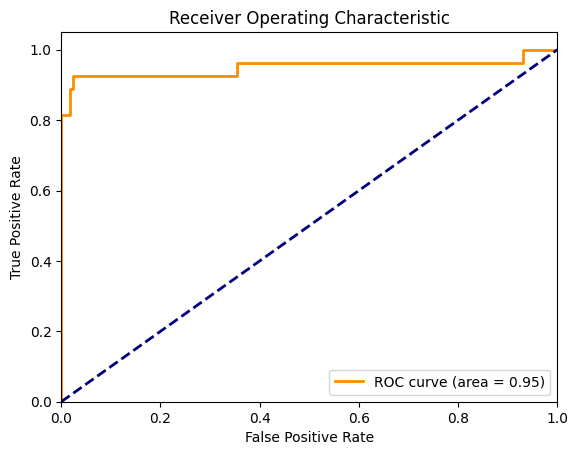

In [20]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [21]:
print(thresholds)

SyntaxError: invalid decimal literal (<ipython-input-22-74682e8d7b02>, line 1)